<a href="https://colab.research.google.com/github/DChulok/I-want-to-learn-NLP/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's prepare the data for the input of BERT tokenizer.

In [2]:
def split_text_label(filename):
    f = open(filename)
    split_labeled_text = []
    sentence = []
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                split_labeled_text.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0],splits[-1].rstrip("\n")])
    if len(sentence) > 0:
        split_labeled_text.append(sentence)
        sentence = []
    sentences = []
    labels = []
    for sent in split_labeled_text:
        sentence = []
        label = []
        for s_l in sent:
            sentence.append(s_l[0])
            label.append(s_l[1])
        sentences.append(sentence)
        labels.append(label)
    return sentences, labels

In [3]:
train_data, train_labels = split_text_label("drive/MyDrive/coNLL/train.txt")
valid_data, valid_labels = split_text_label("drive/MyDrive/coNLL/valid.txt")
test_data, test_labels = split_text_label("drive/MyDrive/coNLL/test.txt")

In [4]:
# the first sentence
train_data[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [5]:
# its tokens
train_labels[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

Lets create tag dictionary

In [6]:
tag_values = set()
for l in train_labels:
    tag_values.update(l)
tag_values.update(["PAD"])
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [7]:
tag2idx

{'B-LOC': 4,
 'B-MISC': 9,
 'B-ORG': 8,
 'B-PER': 0,
 'I-LOC': 6,
 'I-MISC': 1,
 'I-ORG': 2,
 'I-PER': 7,
 'O': 3,
 'PAD': 5}

In [8]:
idx2tag = {v: k for k, v in tag2idx.items()}

### Tokenization with BertTokenizer

BERT (Bidirectional Encoder Representations from Transformers) is a method of pretraining language representations. These vectors (representations) are used as high-quality feature inputs to downstream models. BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them.

In [9]:
!pip install transformers

     |████████████████████████████████| 1.5MB 19.1MB/s 
     |████████████████████████████████| 890kB 48.3MB/s 
     |████████████████████████████████| 2.9MB 47.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ac6da23b50fc70abcde896f54593c893eff08a6fd91f9b728b6b22f686bdc85c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

The Bert implementation comes with a pretrained tokenizer and a definied vocabulary. We load the one related to the smallest pre-trained model bert-base-cased. We use the cased variate since it is well suited for NER.

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [13]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return ['[CLS]'] + tokenized_sentence + ['[SEP]'], ['O'] + labels + ['O']

In [14]:
train_tokenized = [tokenize_and_preserve_labels(s, l, tokenizer) for s, l in zip(train_data, train_labels)]
valid_tokenized = [tokenize_and_preserve_labels(s, l, tokenizer) for s, l in zip(valid_data, valid_labels)]
test_tokenized = [tokenize_and_preserve_labels(s, l, tokenizer) for s, l in zip(test_data, test_labels)]

In [15]:
train_tokens = [x[0] for x in train_tokenized]
train_labels = [x[1] for x in train_tokenized]
valid_tokens = [x[0] for x in valid_tokenized]
valid_labels = [x[1] for x in valid_tokenized]
test_tokens = [x[0] for x in test_tokenized]
test_labels = [x[1] for x in test_tokenized]

In [16]:
MAX_SEQ_LENGTH = np.max([len(sen) for sen in train_tokens])
        
MEAN_SEQ_LENGTH = int(np.mean([len(sen) for sen in train_tokens]))

In [ ]:
DISIRED_LENGTH = MAX_SEQ_LENGTH

Next, we cut and pad the token and label sequences to our desired length.

In [17]:
train_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokens],
                          maxlen=DISIRED_LENGTH, dtype="long", value=0.0,
                          truncating="post", padding="post")
train_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_labels],
                     maxlen=DISIRED_LENGTH, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
valid_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in valid_tokens],
                          maxlen=DISIRED_LENGTH, dtype="long", value=0.0,
                          truncating="post", padding="post")
valid_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in valid_labels],
                     maxlen=DISIRED_LENGTH, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
test_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokens],
                          maxlen=DISIRED_LENGTH, dtype="long", value=0.0,
                          truncating="post", padding="post")
test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=DISIRED_LENGTH, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [18]:
# the first train sentence
train_ids[0]

array([  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495,
       12913,   119,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

We create the masks to ignore the padded elements in the sequences.

In [19]:
train_masks = [[float(i != 0.0) for i in ii] for ii in train_ids]
valid_masks = [[float(i != 0.0) for i in ii] for ii in valid_ids]
test_masks = [[float(i != 0.0) for i in ii] for ii in test_ids]

We have to convert the dataset to torch tensors.

In [20]:
train_inputs = torch.tensor(train_ids)
train_tags = torch.tensor(train_tags)
train_masks = torch.tensor(train_masks)
valid_inputs = torch.tensor(valid_ids)
valid_tags = torch.tensor(valid_tags)
valid_masks = torch.tensor(valid_masks)
test_inputs = torch.tensor(test_ids)
test_tags = torch.tensor(test_tags)
test_masks = torch.tensor(test_masks)

The last step is to define the dataloaders. We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.

In [44]:
# let's set the batch size
BATCH_SIZE = 128

In [45]:
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

### BERT setup

The transformer package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel.

In [23]:
!pip install pytorch-crf

In [24]:
from transformers import BertForTokenClassification, AdamW
from torch import nn
from torchcrf import CRF

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [26]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [27]:
# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-cased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'first'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'


# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

In [28]:
class Our_model(nn.Module):
    """
    BERT+biLSTM+Linear+Relu
    """
    def __init__(self, hidden_size=128, num_labels=len(tag2idx), bert_layers=1, concat=True):
        """
        Creates model
        
        Parameters
        ----------
        batch_size:
        hidden_size:
        num_labels:
        bert_layers: int, default=1
            Num of final BERT hidden layers to be used as embedding vector.
        concat: bool, default=True
            Whether to concat (True) or sum (False) last BERT hidden layers.
        
        """
        super(Our_model, self).__init__()

        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.bert_layers = bert_layers
        self.concat = concat
        
        self.bert = BertForTokenClassification.from_pretrained(
                        BERT_MODEL, #cache_dir=CACHE_DIR,
                        output_hidden_states=True)
        
        for pars in self.bert.parameters():
            pars.requires_grad = False
        
        embedding_dim = self.bert.config.to_dict()['hidden_size']
        
        if self.concat:
            self.bilstm = nn.LSTM(embedding_dim*self.bert_layers, self.hidden_size,
                                  bidirectional=True)
        else:
            self.bilstm = nn.LSTM(embedding_dim, self.hidden_size,
                                  bidirectional=True)
        
        self.linear = nn.Linear(self.hidden_size*2, self.num_labels)
        self.crf = CRF(num_tags=self.num_labels, batch_first=True)
    
    def forward(self, sequence, attention_mask):
        """
        Forward propogate of model.
        
        Parameters
        ----------
        sequence:
        attention_mask:
        
        Returns
        -------
        Logits
        
        """

        bert_hiddens = self.bert(sequence, attention_mask=attention_mask)[1]
        if self.concat:
            bert_embedding = torch.cat(bert_hiddens[-self.bert_layers:], dim=2)#[bert_hiddens[-i] for i in range(-1, -self.bert_layers-1, -1)], dim=0)
        else:
            emb_sum = 0
            for h in bert_hiddens[-self.bert_layers:]:
                emb_sum += h
            bert_embedding = emb_sum
    
        bilstm_output, (h_n, c_n) = self.bilstm(bert_embedding)
        linear_output = nn.functional.relu(self.linear(bilstm_output))
        return linear_output

If we need scheduler

In [29]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
total_steps = len(train_dataloader) * NUM_TRAIN_EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Let's use seqeval library for sequence labeling evaluation

In [30]:
!pip install seqeval

     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=b322893fcceb2ff046c6686e43d3d118a79795eef951638feac345336e876bed
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [39]:
import tqdm
from seqeval.metrics import f1_score, accuracy_score

In [49]:
def train(model, train_dataloader, optimizer, scheduler=None, n_epoch=5,
          max_grad_norm=None, validate=True, valid_dataloader=None,
          show_info=True, save_model=True):
    loss_values = []
    if validate and valid_dataloader is not None:
        validation_loss_values = []
        valid_accuracies = []
        valid_f1_scores = []

    for e in range(n_epoch):
    
        # Training

        model.train()

        total_loss = 0

        if show_info:
            enumerator = enumerate(tqdm.tqdm(train_dataloader, position=0, leave=True))
        else:
            enumerator = enumerate(train_dataloader)

        for step, batch in enumerator:
            if device.type != 'cpu':
                batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            model.zero_grad()

            logits = model.forward(b_input_ids, b_input_mask.byte())
            
            # because we need negative log likelyhood
            loss = -1*model.crf.forward(logits, b_labels, mask=b_input_mask.byte())

            loss.backward()

            total_loss += loss.item()

            if show_info and step+1 % 10 == 0:
                print(f"\n{step}: avg loss per batch: {total_loss/step}\n")

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(parameters=model.parameters(),
                                            max_norm=max_grad_norm)

            optimizer.step()

            if scheduler is not None:
                scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        if show_info:
            print(f"Average train loss: {avg_train_loss}")

        loss_values.append(avg_train_loss)

        if validate and valid_dataloader is not None:
          # Validation

            model.eval()

            eval_loss, eval_accuracy = 0, 0
            predictions, true_labels = [], []

            for batch in valid_dataloader:
                if device.type != 'cpu':
                    batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                with torch.no_grad():
                    logits = model.forward(b_input_ids, b_input_mask.byte())
                    loss = -1*model.crf.forward(logits, b_labels, mask=b_input_mask.byte())
                    tags = model.crf.decode(logits, mask=b_input_mask.byte())

                # move loss to cpu
                eval_loss += loss.item()
                predictions.extend(tags)
                labels_ = b_labels.detach().cpu().numpy()
                true_labels.extend(labels_)

            eval_loss = eval_loss / len(valid_dataloader)
            validation_loss_values.append(eval_loss)
            if show_info:
                print(f"Validation loss: {eval_loss}")

            all_predicted_tags = []
            for s in predictions:
                tag_names = [idx2tag[i] for i in s]
                all_predicted_tags.append(tag_names)

            all_true_tags = []
            for s in true_labels:
                tag_names = [idx2tag[i] for i in s if idx2tag[i] != 'PAD']
                all_true_tags.append(tag_names)

            valid_acc = accuracy_score(all_predicted_tags, all_true_tags)
            valid_f1 = f1_score(all_predicted_tags, all_true_tags)
            valid_accuracies.append(valid_acc)
            valid_f1_scores.append(valid_f1)

            if show_info:
                print(f"Validation accuracy: {valid_acc}")
                print(f"Validation F1-score: {valid_f1}\n")
            
        if save_model and e+1%5 == 0:
            torch.save(model.state_dict(),
                        f'/content/drive/My Drive/models/BERT_biLSTM_oneCRF_{e}_state_dict')
            torch.save(model,
                        f'/content/drive/My Drive/models/BERT_biLSTM_oneCRF_{e}')

    return loss_values, validation_loss_values, valid_accuracies, valid_f1_scores

In [33]:
from sklearn.model_selection import KFold, ParameterGrid
import numpy as np

### Cross-validation

Fix some train parameters


In [34]:
RANDOM_SEED = 42

N_FOLDS = 3

N_EPOCHS = 5

In [ ]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# model = Our_model(batch_size=BATCH_SIZE, hidden_size=128, num_labels=len(tag2idx),
#                     bert_layers=2, concat=False)
# model.to(device)

In [ ]:
# opt = AdamW(params=model.parameters(),lr=1e-3)
# train(model, train_dataloader, opt)

In [ ]:
%time
param_grid = {
    'opt': ['AdamW'],
    'lr': [3e-4, 7e-4, 1e-3],
    'bert_layers': [2,3],
    'concat': [True, False],
    'max_grad_norm': [None]#[1., None]
}

param_grid = {
    'opt': ['AdamW'],
    'lr': [1e-3],
    'bert_layers': [2],
    'concat': [False],
    'max_grad_norm': [None]
}

grid = ParameterGrid(param_grid)

params_results = {}

for m, ps in enumerate(grid):
  print(f"Model #{m} of {len(grid)}")
  _p_r = {'params': ps}
  
  mean_train_losses = 0
  mean_valid_losses = 0
  mean_valid_accs = 0
  mean_valid_f1s = 0

  for i, (train_index, valid_index) in enumerate(kf.split(train_data)):
    train_fold = torch.utils.data.Subset(train_data, train_index)
    valid_fold = torch.utils.data.Subset(train_data, valid_index)
    train_dataloader = DataLoader(train_fold, batch_size=BATCH_SIZE)
    valid_dataloader = DataLoader(valid_fold, batch_size=BATCH_SIZE)

    model = Our_model(batch_size=BATCH_SIZE, hidden_size=128, num_labels=len(tag2idx),
                    bert_layers=ps['bert_layers'], concat=ps['concat'])
    model.to(device)

    if ps['opt'] == 'Adam':
      optimizer = torch.optim.Adam(params=model.parameters(),lr=ps['lr'])
    else:
      optimizer = AdamW(params=model.parameters(),lr=ps['lr'])

    train_losses, valid_losses, valid_accs, valid_f1s = train(model,
                                            train_dataloader,
                                            optimizer,
                                            n_epoch=N_EPOCHS,
                                            max_grad_norm=ps['max_grad_norm'],
                                            valid_dataloader=valid_dataloader,
                                            show_info=False)
    
    mean_train_losses += np.array(train_losses)
    mean_valid_losses += np.array(valid_losses)
    mean_valid_accs += np.array(valid_accs)
    mean_valid_f1s += np.array(valid_f1s)
  
  mean_train_losses /= N_FOLDS
  mean_valid_losses /= N_FOLDS
  mean_valid_accs /= N_FOLDS
  mean_valid_f1s /= N_FOLDS
  _p_r['mean_train_losses'] = list(mean_train_losses)
  _p_r['mean_valid_losses'] = list(mean_valid_losses)
  _p_r['mean_valid_accs'] = list(mean_valid_accs)
  _p_r['mean_valid_f1s'] = list(mean_valid_f1s)
  params_results[m] = _p_r 

with open("/content/drive/My Drive/params_results.json", "w") as w:
  json.dump(params_results, w)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs
Model #0 of 1


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas


20: avg loss per batch: 1617.4231414794922



 28%|██▊       | 41/147 [01:05<02:50,  1.61s/it]


40: avg loss per batch: 1296.011669921875



 41%|████▏     | 61/147 [01:38<02:20,  1.63s/it]


60: avg loss per batch: 1077.3345855712892



 55%|█████▌    | 81/147 [02:10<01:47,  1.62s/it]


80: avg loss per batch: 944.4252662658691



 69%|██████▊   | 101/147 [02:43<01:14,  1.62s/it]


100: avg loss per batch: 850.7808702087402



 82%|████████▏ | 121/147 [03:15<00:42,  1.63s/it]


120: avg loss per batch: 786.6331132253011



 96%|█████████▌| 141/147 [03:47<00:09,  1.63s/it]


140: avg loss per batch: 735.3509732927595



100%|██████████| 147/147 [03:56<00:00,  1.61s/it]


Average train loss: 713.9020969883925
Validation loss: 372.75581205213393
Validation accuracy: 0.9209505966276262
Validation F1-score: 0.637548360822643



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas


20: avg loss per batch: 1696.0400024414062



 28%|██▊       | 41/147 [01:06<02:52,  1.62s/it]


40: avg loss per batch: 1367.6191986083984



 41%|████▏     | 61/147 [01:38<02:19,  1.62s/it]


60: avg loss per batch: 1174.6481643676757



 55%|█████▌    | 81/147 [02:11<01:46,  1.61s/it]


80: avg loss per batch: 1050.1587001800538



 69%|██████▊   | 101/147 [02:43<01:14,  1.63s/it]


100: avg loss per batch: 954.4015658569336



 82%|████████▏ | 121/147 [03:16<00:42,  1.62s/it]


120: avg loss per batch: 883.1334081013997



 96%|█████████▌| 141/147 [03:48<00:09,  1.62s/it]


140: avg loss per batch: 816.914501953125



100%|██████████| 147/147 [03:57<00:00,  1.62s/it]


Average train loss: 791.2801903186202
Validation loss: 366.5140425192343
Validation accuracy: 0.9262171758711308
Validation F1-score: 0.6517533654645172



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas


20: avg loss per batch: 1616.4193389892578



 28%|██▊       | 41/147 [01:06<02:52,  1.62s/it]


40: avg loss per batch: 1304.3155166625977



 41%|████▏     | 61/147 [01:39<02:20,  1.63s/it]


60: avg loss per batch: 1125.9469146728516



 55%|█████▌    | 81/147 [02:11<01:47,  1.63s/it]


80: avg loss per batch: 1016.968473815918



 69%|██████▊   | 101/147 [02:44<01:14,  1.62s/it]


100: avg loss per batch: 933.1552807617187



 82%|████████▏ | 121/147 [03:16<00:42,  1.62s/it]


120: avg loss per batch: 872.736432393392



 96%|█████████▌| 141/147 [03:49<00:09,  1.63s/it]


140: avg loss per batch: 821.423418535505



100%|██████████| 147/147 [03:57<00:00,  1.62s/it]


Average train loss: 796.8750567014525
Validation loss: 413.38719300966005
Validation accuracy: 0.9110786019294639
Validation F1-score: 0.577678659276508



In [ ]:
import json

In [ ]:
with open("/content/drive/My Drive/params_results.json", "w") as w:
  json.dump(params_results, w)

After train on 1 epoch on small dataset the best result gave the model that concatenates two last bert layers and has learning rate 3e-4, so let's train such model on all train data. Also, let's increase LSTM hidden size to be 512 and use now linear scheduler.

### Final model train

In [46]:
N_EPOCHS = 20

In [47]:
total_steps = len(train_dataloader) *  N_EPOCHS

In [38]:
model = Our_model(hidden_size=512, bert_layers=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [50]:
optimizer = AdamW(params=model.parameters(),lr=3e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

#train_losses, valid_losses, valid_accs, valid_f1s
results = train(model, train_dataloader, optimizer, scheduler, n_epoch=N_EPOCHS,
     validate=True, valid_dataloader=valid_dataloader)

100%|██████████| 110/110 [03:54<00:00,  2.14s/it]


Average train loss: 1515.7984602494673
Validation loss: 922.5538300734299


/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9005077369439072
Validation F1-score: 0.5592313787638669



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 907.421474942294
Validation loss: 775.7211004403921


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9143026004728132
Validation F1-score: 0.6072816914762492



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 790.9373019131747
Validation loss: 722.1079527047964


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9205082742316785
Validation F1-score: 0.6243977645018308



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 744.483608453924
Validation loss: 688.2383188100962


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9238797549967763
Validation F1-score: 0.6283240568954853



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 695.077719671076
Validation loss: 601.0222490750826


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9338464431549538
Validation F1-score: 0.6601783531755013



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 455.60315496271306
Validation loss: 400.2392179048978


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9589243498817966
Validation F1-score: 0.8050269935392512



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 395.889284584739
Validation loss: 379.97282233605017


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9599049000644745
Validation F1-score: 0.8101243417850348



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 364.44260031960226
Validation loss: 355.1831443493183


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9628062540296582
Validation F1-score: 0.8219238388729914



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 345.7866388494318
Validation loss: 344.6349248152513


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9635315925209542
Validation F1-score: 0.8288049480892424



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 325.8881949684837
Validation loss: 333.3132481208214


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9650628626692457
Validation F1-score: 0.8354029062087185



100%|██████████| 110/110 [04:16<00:00,  2.34s/it]


Average train loss: 312.09522483132105
Validation loss: 326.7483105292687


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9657210401891253
Validation F1-score: 0.8443534751268131



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 302.5128107244318
Validation loss: 314.900939647968


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9663926499032882
Validation F1-score: 0.8442362093352193



100%|██████████| 110/110 [04:17<00:00,  2.34s/it]


Average train loss: 289.12545332475145
Validation loss: 307.23546835092395


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9674403610573823
Validation F1-score: 0.8465524813350901



100%|██████████| 110/110 [04:16<00:00,  2.34s/it]


Average train loss: 281.5702273282138
Validation loss: 301.28488966134876


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9683537502686439
Validation F1-score: 0.8556609628513167



100%|██████████| 110/110 [04:16<00:00,  2.33s/it]


Average train loss: 274.53245586048473
Validation loss: 298.18709622896637


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9678567590801633
Validation F1-score: 0.8509322258549086



100%|██████████| 110/110 [04:18<00:00,  2.35s/it]


Average train loss: 268.1180124456232
Validation loss: 294.5428739694449


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9692805716741887
Validation F1-score: 0.8582036775106081



100%|██████████| 110/110 [04:19<00:00,  2.35s/it]


Average train loss: 263.7407508156516
Validation loss: 292.30063717181866


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.969455190199871
Validation F1-score: 0.8591031826833695



100%|██████████| 110/110 [04:19<00:00,  2.36s/it]


Average train loss: 259.78271151455965
Validation loss: 290.6791059053861


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9697372662798195
Validation F1-score: 0.8614825967584802



100%|██████████| 110/110 [04:18<00:00,  2.35s/it]


Average train loss: 256.34431832053446
Validation loss: 289.5137020991399


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9694820545884376
Validation F1-score: 0.8607236172003012



100%|██████████| 110/110 [04:19<00:00,  2.36s/it]


Average train loss: 253.86109688498757
Validation loss: 288.98256316551794
Validation accuracy: 0.96965667311412
Validation F1-score: 0.8615780369893999



In [56]:
import matplotlib
from matplotlib import pyplot as plt

Let's continue to train model for more 10 epochs with lr=1e-4 and than for more 5 epochs with lr=5e-5

In [94]:
N_EPOCHS = 5
total_steps = len(train_dataloader) *  N_EPOCHS

optimizer = AdamW(params=model.parameters(),lr=5e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

#train_losses, valid_losses, valid_accs, valid_f1s
results = train(model, train_dataloader, optimizer, scheduler, n_epoch=N_EPOCHS,
     validate=True, valid_dataloader=valid_dataloader)

100%|██████████| 110/110 [04:18<00:00,  2.35s/it]


Average train loss: 218.34138162786311
Validation loss: 261.4205064039964


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9725580270793037
Validation F1-score: 0.8726148409893992



100%|██████████| 110/110 [04:19<00:00,  2.36s/it]


Average train loss: 213.15009973699395
Validation loss: 260.51706049992487


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9722087900279389
Validation F1-score: 0.873259423503326



100%|██████████| 110/110 [04:19<00:00,  2.36s/it]


Average train loss: 211.4877614107999
Validation loss: 261.66430311936597


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9722893831936386
Validation F1-score: 0.8750499711277929



100%|██████████| 110/110 [04:18<00:00,  2.35s/it]


Average train loss: 208.97610126842153
Validation loss: 260.1425795921913


  0%|          | 0/110 [00:00<?, ?it/s]

Validation accuracy: 0.9722222222222222
Validation F1-score: 0.8732869117842729



100%|██████████| 110/110 [04:20<00:00,  2.37s/it]


Average train loss: 207.5255937056108
Validation loss: 260.6407940204327
Validation accuracy: 0.9722893831936386
Validation F1-score: 0.8742727716836168



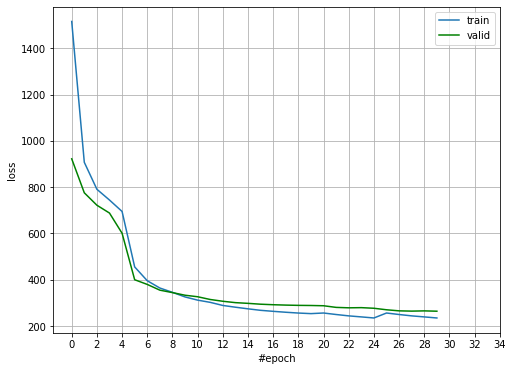

In [92]:
plt.figure(figsize=(8,6))
plt.plot(all_results['train_losses'], label='train')
plt.plot(all_results['valid_losses'], label='valid', c='g')
plt.ylabel("loss")
plt.xlabel("#epoch")
plt.xticks(np.arange(0,35,2))
plt.grid()
plt.legend()
plt.show()

In [95]:
model.eval()
test_losses = []
true_labels = []
pred_labels = []
for step, batch in enumerate(test_dataloader):
    # add batch to gpu
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    batch_true_labels = b_labels
    for bl in batch_true_labels.detach().cpu().tolist():
      tag_names = [idx2tag[i] for i in bl if idx2tag[i] != 'PAD']
      true_labels.append(tag_names)
    
    # Always clear any previously calculated gradients before performing a backward pass.
    # forward pass
    # This will return the loss (rather than the model output)
    # because we have provided the `labels`.
    with torch.no_grad():
        logits = model.forward(b_input_ids, b_input_mask.byte())
        loss = model.crf.forward(logits, b_labels, b_input_mask.byte())
        test_losses.append(loss.item())
        tags = model.crf.decode(logits, b_input_mask.byte())
    for t in tags:
      tag_names = [idx2tag[i] for i in t]
      pred_labels.append(tag_names)


In [96]:
f1_score(true_labels, pred_labels)

0.8297289898713386

In [97]:
torch.save(model, '/content/drive/My Drive/models/BERT_biLSTM_oneCRF')

In [98]:
torch.save(model.state_dict, '/content/drive/My Drive/models/BERT_biLSTM_oneCRF_state_dict')

In [32]:
model = torch.load('/content/drive/My Drive/models/BERT_biLSTM_oneCRF',
                   map_location=torch.device('cpu'))